# Tutorial: TensorNet
This notebook will go step by step through one forward pass of the TensorNet architecture.

In [47]:
import torch
from matplotlib import pyplot as plt
from tensornet import *
from sympy import Matrix
import numpy as np

## Data generation
The way the model is implemented, the input for a forward pass consists of a batch of $M$ molecules made up by $N$ atoms in total. For the purpose of this notebook we will create a batch with $M=2$ molecules that are made up by $N=7$ atoms ins total.

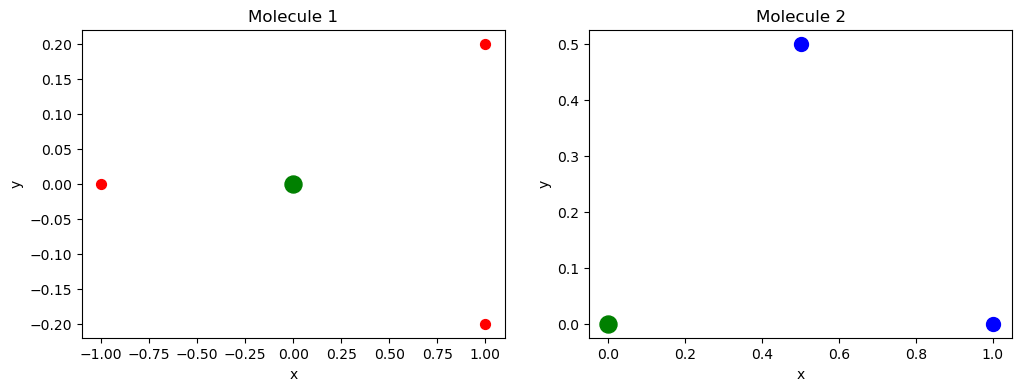

In [29]:
# create 2 molecules with 7 atoms
pos = [[0, 0, 0], [-1, 0, 0], [1, 0.2, 0], [1, -0.2, 0], [0, 0, 0], [1, 0, 0], [0.5, 0.5, 0]]
batch = [0, 0, 0, 0, 1, 1, 1]
atom_ind = [2, 0, 0, 0, 2, 1, 1]
# plot the two molecules
fig, ax = plt.subplots(1,2, figsize=(12,4))
colors = ['r', 'b', 'g']
for atom, mol, ind  in zip(pos, batch, atom_ind):
    ax[mol].scatter(atom[0], atom[1], c=colors[ind], s=50*(ind+1))
ax[0].set_title('Molecule 1')
ax[1].set_title('Molecule 2')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y');

As we can see here, a molecule $\mathcal{M}_i$ is defined by its number of atoms $N_i$, the position of the atoms $\{\vec{r}_n,n=1,...,N_i\}$ and their atomic numbers $\{Z_n,n=1,...,N_i\}$ (where this do not have to be the real atomic number, but they should be different for different atoms).

The way that the model is written, the input to the forward method is an object `batch_input` that has these information as attributes:
- `batch_input.pos`: A tensor of shape $[N,3]$, where the positions of all $N$ atoms are stored
- `batch_input.atom_ind`: A tensor of shape $N$ with the atomic numbers of the $N$ atoms
- `batch_input.batch`: A tensor of shape $[N]$, that defines which atom belongs to which molecule. In our case it would be $[0, 0, 0, 0, 1, 1, 1]$ defining that the first $4$ atoms build the first molecule and the next $3$ the second. Generally this defines the number of molecules $M$ by `max(batch_input.batch)+1=M`.

In [31]:
# define input class
class input():
    def __init__(self, pos, batch, atom_ind):
        self.pos = torch.tensor(pos, dtype=torch.float32)
        self.batch = torch.tensor(batch, dtype=torch.int32)
        self.atom_ind = torch.tensor(atom_ind, dtype=torch.int32)
# define input object
batch_input = input(pos, batch, atom_ind)

## Model initialization

Now we need to initialize the model with the appropriate hyperparameters.

In [43]:
# initialize model
model = TensorNet(hidden_channels = 2,
                 num_layers = 1,
                 max_z = 3,
                 num_rbf = 5,
                 cutoff_lower = 0.0, 
                 cutoff_upper = 1.1, 
                 max_num_neighbors = 3, 
                 activation="silu",
                 equivariance_invariance_group="O(3)",
                 check_errors = True, 
                 static_shapes = True,
                 trainable_rbf = True,
                 dtype="torch.float32")
# do the forward pass
output = model(batch_input)
print('Model output:', output)  

Model output: tensor([2.0773, 1.5364], grad_fn=<SumBackward1>)


We can see that the model output are $M$ scalars, describing a scalar quantity (like energy) of the molecules. 